In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import rescale, resize

In [2]:
df = pd.read_csv("csv_files/USpreprocessed.csv")
df2 = pd.read_csv("csv_files/GBpreprocessed.csv")

In [3]:
df.dropna(inplace=True)
df2.dropna(inplace=True)
#print(df['category_id'].dtype)

In [4]:
#all categories are same. Britain doesn't have 29, hence dropping it from US dataframe

df.drop(df[df['category_id']==29].index,inplace=True)

In [5]:
df.drop_duplicates("video_id", keep="last", inplace=True,ignore_index=True)
df2.drop_duplicates("video_id",keep="last",inplace=True,ignore_index=True)
print(df2.shape)
df.to_csv('csv_files/USduplicates.csv')
df2.to_csv('csv_files/GBduplicates.csv')

(3213, 20)


In [6]:
df.drop("thumbnail_link", axis=1, inplace=True)
df2.drop("thumbnail_link", axis=1, inplace=True)

df_stat = pd.read_csv('image_data/USpics/status.csv')
df2_stat = pd.read_csv('image_data/GBpics/status.csv')


df['image_status'] = df_stat['0']
df['image_status'] = df['image_status'].astype(bool)

df2['image_status'] = df2_stat['0']
df2['image_status'] = df2['image_status'].astype(bool)


df['file_path'] = np.nan
df['file_path'] = df['file_path'].astype(str)
df2['file_path'] = np.nan
df2['file_path'] = df2['file_path'].astype(str)

for i in range(df.shape[0]):
    if df.iloc[i]['image_status'] == True:
        df.at[i,'file_path'] = "image_data/USpics/image-{}.jpg".format(i)


for i in range(df2.shape[0]):
    if df2.iloc[i]['image_status'] == True:
        df2.at[i,'file_path'] = "image_data/GBpics/image-{}.jpg".format(i)

        
df.drop(df[df['image_status']==False].index,inplace=True)
df.drop(columns=['image_status'],inplace=True)

        
df2.drop(df2[df2['image_status']==False].index,inplace=True)
df2.drop(columns=['image_status'],inplace=True)


df = pd.concat([df,df2],ignore_index=True)
df.drop(df[df['file_path']=="image_data/GBpics/image-916.jpg"].index,inplace=True)
df.shape


(8608, 20)

In [7]:
import os
list_of_images = []
for file_path in df['file_path']:
    img = mpimg.imread(file_path)
    if img.shape != (90,120,3):
        print("Yayy")
        print(file_path)
    img = np.transpose(img,(2,0,1))
    list_of_images.append(img)


df.drop(columns=['file_path'],inplace=True)


In [8]:
print(len(list_of_images))
print(list_of_images[0].shape)
list_of_images = np.array(list_of_images)
print(list_of_images.shape)

8608
(3, 90, 120)
(8608, 3, 90, 120)


In [9]:
for i in range(len(list_of_images)):
    list_of_images[i] = (list_of_images[i]-128)/256

In [10]:
df.drop(["video_id"], axis=1, inplace=True)

In [11]:
df_x = df.drop("category_id", axis=1)
df_y = pd.get_dummies(df["category_id"], prefix="cat")

In [12]:
#tokenize this
df_x["text"]=df_x["title"]+" "+df_x["channel_title"]+" "+df_x["description"]

In [13]:
df_x.drop(["title", "channel_title", "description"], axis=1, inplace=True)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer(ngram_range=(1,2), max_df=0.5, max_features=10000)

In [15]:
vectorized_text = vectorizer.fit_transform(df_x["text"])

In [16]:
vectorized_text.shape

(8608, 10000)

In [17]:
from sklearn.decomposition import PCA
pca=PCA(n_components=1000)

In [18]:
vec_text_pca = pca.fit_transform(vectorized_text.todense())

In [19]:
pca.explained_variance_ratio_.sum()

0.7051210335501265

In [20]:
df_x.drop("text", axis=1, inplace=True)

In [21]:
x=df_x.to_numpy()
y = df_y.to_numpy()
x=np.c_[x, vec_text_pca]
print(x.shape)
print(y.shape)

(8608, 1014)
(8608, 16)


In [22]:
import numpy as np
import torch
from torch.utils.data import Dataset , DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
tsfm = StandardScaler()

X_train ,X_test, y_train, y_test = train_test_split(x,y,train_size=0.85,shuffle=False)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_test = y_test.astype(np.float64)
y_train = y_train.astype(np.float64)
X_train = tsfm.fit_transform(X_train)

tsfm = StandardScaler()
X_test = tsfm.fit_transform(X_test)

#list_of_images = np.array(list_of_images)
train_images = list_of_images[:7316]
test_images = list_of_images[7316:]
print(train_images.shape)
np.random.seed(0)

(7316, 1014)
(1292, 1014)
(7316, 16)
(1292, 16)
(7316, 3, 90, 120)


In [24]:
# numpy arrays have the __len__ and __getitem__ functions by default so not sure if we need this
class trainData(Dataset):
    
    def __init__(self, X_data,X_img, y_data):
        self.X_data = X_data
        self.X_img = X_img
        self.y_data = y_data
        
    def __getitem__(self, index):
        return (self.X_data[index],self.X_img[index]), self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train),torch.FloatTensor(train_images), torch.FloatTensor(y_train))


class testData(Dataset):
    
    def __init__(self, X_data,X_img,y_data):
        self.X_data = X_data
        self.X_img = X_img
        self.y_data = y_data
        
    def __getitem__(self, index):
        return (self.X_data[index],self.X_img[index]), self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test),torch.FloatTensor(test_images),torch.FloatTensor(y_test))

print("Length of training data is: {}".format(len(train_data)))
print("Length of test data is: {}".format(len(test_data)))

Length of training data is: 7316
Length of test data is: 1292


In [25]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE)

In [26]:
class MyNet(nn.Module):
    def __init__(self):
        
        super(MyNet, self).__init__()        
        self.layer1 = nn.Linear(X_train.shape[1], 512) 
        
        self.layer2 = nn.Linear(512, 128)
        self.layer3 = nn.Linear(128, y_train.shape[1])
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        
        
        
        #self.batchnorm1 = nn.BatchNorm1d(hidden)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 19 * 27, 128)
        self.fc2 = nn.Linear(256, 16)
        self.fc3 = nn.Linear(64,16)
        
    def forward(self, inputs):
        text_data = inputs[0]
        img_data = inputs[1]
        
        x = self.relu1(self.layer1(text_data))
        x = F.dropout(x,0.4)
        x = self.relu2(self.layer2(x))
        #x = F.dropout(x,p=0.4)
        #x = self.relu3(self.layer3(x))
        #x = F.log_softmax(x,dim=1)
        
        
        
        y = self.pool(F.relu(self.conv1(img_data)))
        y = F.dropout(y,0.3)
        y = self.pool(F.relu(self.conv2(y)))
        
        y = y.view(-1, 16 *19*27)
        y = F.relu(self.fc1(y))
        
        z = (self.fc2(torch.cat((x,y),dim=1)))
        #z = self.fc3(z)
        z = F.log_softmax(z,dim=1)
        
        return z

In [27]:
model = MyNet()
print(model)

MyNet(
  (layer1): Linear(in_features=1014, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=16, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=8208, out_features=128, bias=True)
  (fc2): Linear(in_features=256, out_features=16, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
)


In [28]:
EPOCHS = 40
LEARNING_RATE = 0.01
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.NLLLoss()

train_losses = []
train_accuracies = []
test_losses = []

test_accuracies = []

for e in range(1, EPOCHS+1):

    model.train()
    
    epoch_loss = 0
    correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        
        #X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch)
        #print(y_pred.size())
        loss = criterion(y_pred, torch.max(y_batch,1)[1])
        loss.backward()
        optimizer.step()
        
        
        predicted = torch.max(y_pred.data, 1)[1]     
        y_temp = torch.max(y_batch.data,1)[1]
        correct += (predicted == y_temp).sum()
        total += float(len(y_batch))
        
        
        epoch_loss += loss.item()
        
    train_accuracies.append(correct*100/total)
    train_losses.append(epoch_loss/len(train_loader))
    if (e+1)%4==0:
        print(f'Train Accuracy | Epoch {e+1:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {correct*100/total:.3f}')

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct_val = 0
        total_val = 0
        for X_val, y_val in test_loader:
            #X_val, y_val = X_val.to(device), y_val.to(device)

            y_predval = model(X_val)
            loss = criterion(y_predval,torch.max(y_val,1)[1])
            
            predicted = torch.max(y_predval.data, 1)[1] 
            y_temp = torch.max(y_val.data,1)[1]
            
            correct_val += (predicted == y_temp).sum()
            total_val += float(len(y_val))
            
            
            test_loss += loss.item()

    test_accuracies.append(float(correct_val*100/total_val))
    test_losses.append(test_loss/len(test_loader))
    if (e+1)%4==0:
        print(f'Valid Accuracy | Epoch {e+1:03}: | Loss: {test_loss/len(test_loader):.5f} | Acc: {correct_val*100/total_val:.3f}\n')


/home/sumeet/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Train Accuracy | Epoch 004: | Loss: 2.23300 | Acc: 27.365
Valid Accuracy | Epoch 004: | Loss: 2.09872 | Acc: 28.715

Train Accuracy | Epoch 008: | Loss: 1.51804 | Acc: 59.623
Valid Accuracy | Epoch 008: | Loss: 1.53723 | Acc: 55.650

Train Accuracy | Epoch 012: | Loss: 0.70989 | Acc: 82.121
Valid Accuracy | Epoch 012: | Loss: 1.13083 | Acc: 69.737

Train Accuracy | Epoch 016: | Loss: 0.37160 | Acc: 90.883
Valid Accuracy | Epoch 016: | Loss: 1.07346 | Acc: 71.981

Train Accuracy | Epoch 020: | Loss: 0.21776 | Acc: 94.710
Valid Accuracy | Epoch 020: | Loss: 1.15526 | Acc: 70.820

Train Accuracy | Epoch 024: | Loss: 0.13518 | Acc: 97.198
Valid Accuracy | Epoch 024: | Loss: 1.12685 | Acc: 72.523

Train Accuracy | Epoch 028: | Loss: 0.08947 | Acc: 98.387
Valid Accuracy | Epoch 028: | Loss: 1.18228 | Acc: 72.833

Train Accuracy | Epoch 032: | Loss: 0.06748 | Acc: 98.756
Valid Accuracy | Epoch 032: | Loss: 1.26300 | Acc: 73.220

Train Accuracy | Epoch 036: | Loss: 0.05233 | Acc: 99.030
Valid 

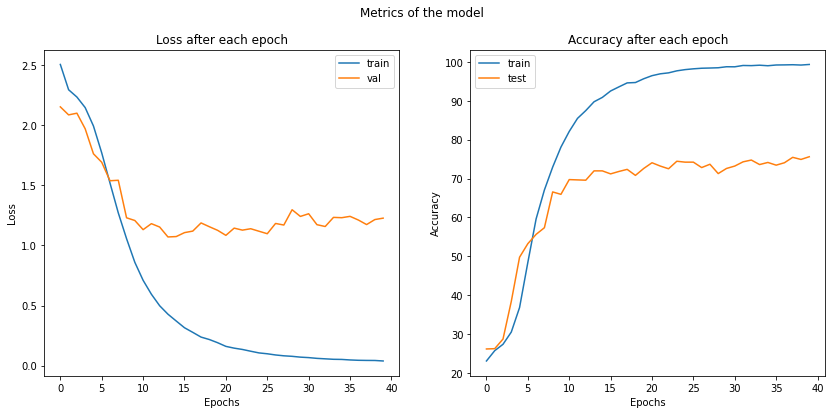

In [31]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(14,6))

ax[0].plot(train_losses,label='train')
ax[0].plot(test_losses,label='val')
ax[0].set_title("Loss after each epoch")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(train_accuracies,label='train')
ax[1].plot(test_accuracies,label='test')
ax[1].set_title("Accuracy after each epoch")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

fig.suptitle("Metrics of the model")
plt.show()